# Lasso implementation using ADMM(Alternating Direction Method of Multipliers)
Comparison of denoizing signals using Lasso by sklearn implementation.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 1

## Generate sparce signal and apply random-linear transform

In [2]:
# fix the seed of random
np.random.seed(0)

In [26]:
# Generate signal
idx = np.random.randint(0, 1000, 20)
signal = np.zeros(1000)
signal[idx] = np.random.normal(0.0, 1.0, 20)

In [47]:
# Generate observation matrix(random) and observation result
A = np.random.normal(0.0, 1.0, (100, 1000))
y = A.dot(signal)

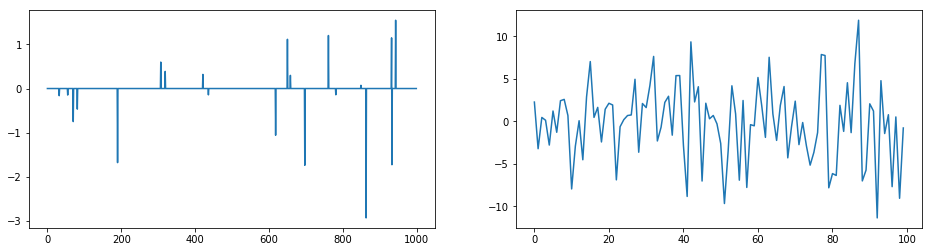

In [48]:
# Plot signal and result
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(signal)
plt.subplot(1,2,2)
plt.plot(y)
plt.show()

## Compare implementations

In [37]:
import sys
sys.path.append('..')

from sklearn.linear_model import Lasso
from spmimage.linear_model import LassoADMM

In [94]:
def get_lasso_signal(X):
    model = Lasso(alpha=0.1)
    model.fit(X, y)
    return model.coef_, model.predict(X)

def get_lasso_admm_signal(X):
    model = LassoADMM(alpha=0.1)
    model.fit(X, y)
    return model.coef_, model.predict(X)

In [100]:
lasso_signal, lasso_predict = get_lasso_signal(A)
lasso_admm_signal, lasso_admm_predict = get_lasso_admm_signal(A)

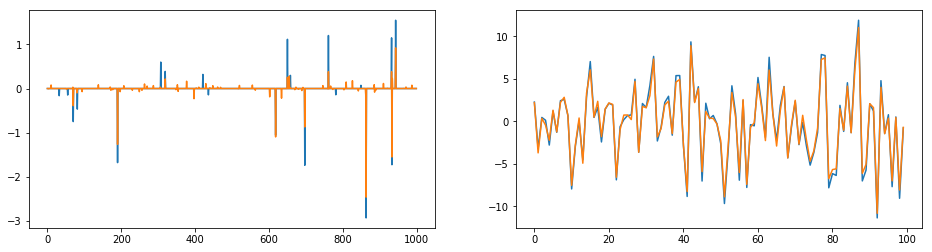

In [101]:
# Plot signal and result (sklearn)
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(signal)
plt.plot(lasso_signal)
plt.subplot(1,2,2)
plt.plot(y)
plt.plot(lasso_predict)
plt.show()

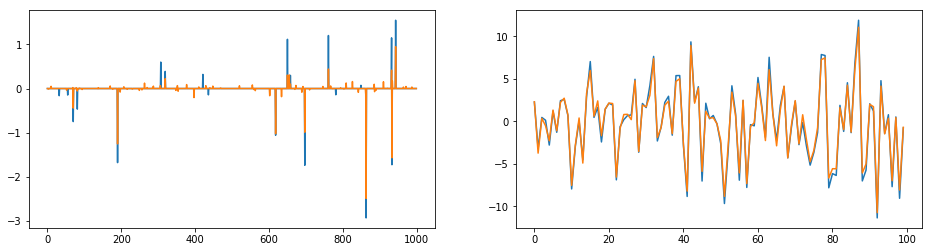

In [102]:
# Plot signal and result (ADMM)
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(signal)
plt.plot(lasso_admm_signal)
plt.subplot(1,2,2)
plt.plot(y)
plt.plot(lasso_admm_predict)
plt.show()